# Group Relative Policy Optimization: GRPO

We consider a simple instance of GRPO as defined in [DeepSeekMath: Pushing the Limits of Mathematical Reasoning in Open Language Models](https://arxiv.org/abs/2402.03300).

The genral objective is to learn a policy $\pi_{\theta}(o|q)$ where $o$ is the outputt for the question (prompt) $q$. In the case of the deepseek pape, $q$ is a math problem and $o$ is chain of thought leading to sht solution.
GRPO optimizes the following objective:
$$
\max_\theta \mathbb{E}_q \mathbb{E}_{\pi_{\text{old}}} f\left(\frac{\pi_{\theta}(o|q)}{\pi_{\text{old}}(o|q)}, A(o) \right) -\beta \text{KL}(\pi_\theta\| \pi_{\text{ref}}),
$$
where $A(o)$ is the advantage of output $o$, $f(r,a) = \min(ra,\text{clip}(r, 1-\epsilon, 1+\epsilon) a)$ and $\text{KL}$ is the Kullback-Leibler divergence.

Note that before any gradient step is made to update $\theta$, we have $\pi_{\theta} = \pi_{\text{old}}$ so that $\frac{\pi_{\theta}(o|q)}{\pi_{\text{old}}(o|q)}=1$ but for $r\in [1-\epsilon, 1+\epsilon]$, we have $f(r,a) = ra$. Hence if only one gradient step is made in the GRPO iteration (i.e. if $\mu=1$) in the pseudo-code below (from the paper):

![algo_grpo_deepseekmath](https://raw.githubusercontent.com/dataflowr/notebooks/master/llm/images/algo_grpo_deepseekmath.png)


Then Equation (21) referred above can be simplified as (in practive average are empirical means):
$$
\mathbb{E}_q \mathbb{E}_{\pi_{\text{old}}} \left(\frac{\pi_{\theta}(o|q)}{\pi_{\text{old}}(o|q)} A(o) \right) -\beta \text{KL}(\pi_\theta\| \pi_{\text{ref}}).
$$
For a given reward function $r_{\phi}(o)$, the advantage $A(o)$ is computed as follows: for a given question $q$, we sample a group of outputs $(o_1,\dots, o_G)$ according to $\pi_{\text{old}}(o|q)$ and compute the corresponding rewards $(r_1=r_\phi(o_1),\dots, r_G=r_{\phi}(o_G))$. Then we define the advantage as: $A(o_i) = \frac{r_i - \textbf{mean}(r_1,\dots, r_G)}{\textbf{std}(r_1,\dots, r_G)}$, so that Equation (21) becomes:
$$
\mathbb{E}_q \frac{1}{G}\sum_{g=1}^G \left(\frac{\pi_{\theta}(o_g|q)}{\pi_{\text{old}}(o_g|q)} A(o_g) \right) -\beta \text{KL}(\pi_\theta\| \pi_{\text{ref}}).
$$

# Gaussian GRPO

We consider a simple setting where there is only one question $q$, the reward function $r_\phi$ is fixed and the policy is Gaussian: $\pi_\theta =\mathcal{N}(\theta, 1)$. The goal of GRPO is to find a target $\theta^* \in \mathbb{R}$ by updating the intial policy $\pi_{theta_0}$ so that in the end $\theta\approx \theta^*$. GRPO will have access to a reward function $r(\theta)$ with the reward giving higher values when its argument $\theta$ is close to $\theta^*$. Our setting is very simple, we will not need the regularization term with the $\text{KL}$ and we will concentrate on the impact of the Group Relative Policy Optimization.

In the code below, we explore the impact of the reward on GRPO and plot the optimization landscape of GRPO, i.e. in the space of parameters, the function optimized by GRPO.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass
from mpl_toolkits.mplot3d import Axes3D

In our Gaussian GRPO, we have
\begin{align}
\frac{\pi_{\theta}(o)}{\pi_{\text{old}}(o)} &= \exp(-(o-\theta)^2/2 + (o-\theta_{\text{old}})^2/2)\\
\nabla_\theta \frac{\pi_{\theta}(o)}{\pi_{\text{old}}(o)} &= (o-\theta)\exp(-(o-\theta)^2/2 + (o-\theta_{\text{old}})^2/2)
\end{align}
Below is the corresponding code:

In [2]:
@dataclass
class Config:
    lower_target = -0.5
    theta_0 = -10
    alpha = 0.01
    delta = 2
    
class Gauss_GRPO:
    def __init__(self, config):
        self.lower_target = config.lower_target
        self.upper_target = -config.lower_target
        self.theta_0 = config.theta_0
        self.alpha = config.alpha
        self.delta = config.delta

    def ratio_policy(self, x, theta):
        return np.exp(-((x - theta) ** 2) / 2 + (x - self.theta_0) ** 2 / 2)
            
    def surrogate_obj(self, x_samples, theta):
        return self.ratio_policy(x_samples, theta)*self.advantage_grpo(x_samples)
    
    def reward(self, x):
        if (x >= self.lower_target) & (x <= self.upper_target):
            return 1 - self.alpha + self.alpha*np.exp(-(x-self.delta) **2/2)
        else:
            return self.alpha*np.exp(-(x-self.delta) **2 /2)
            
    def advantage_grpo(self, x_samples):
        r_batch = np.array([self.reward(x) for x in x_samples])
        return (r_batch - np.mean(r_batch)) / (np.std(r_batch) + 1e-8)

    def sample_batch(self, n_samples):
        return np.random.normal(loc=self.theta_0, scale=1, size=n_samples)

    def empirical_grad(self, x_samples):
        # only one step so ratio_policy = 1 and derivative (x-mu)*adv
        return np.mean((x_samples-self.theta_0)*self.advantage_grpo(x_samples))

    def group_grad(self, n_samples):
        x_samples = self.sample_batch(n_samples)
        grad = self.empirical_grad(x_samples)
        return grad

In [3]:
c = Config()
g = Gauss_GRPO(c)

Below, we consider 3 different reward functions corresponding to a target $t=0$: $r_\alpha(\theta) = (1-\alpha)\mathbf{1}(\theta\in [-\eta,\eta])+\alpha \exp(-(\theta-\delta)^2/2$ for $\alpha=0, 0.01$ and $0.001$.

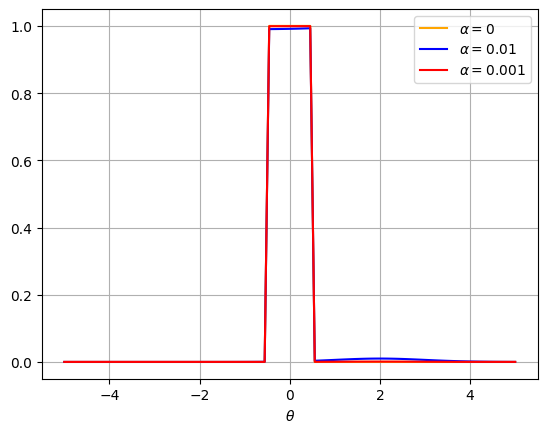

In [4]:
X_range = np.linspace(-5, 5, 100)
g.alpha=0.0
plt.plot(X_range, [g.reward(x) for x in X_range], color='orange', label="$\\alpha=0$")
g.alpha=0.01
plt.plot(X_range, [g.reward(x) for x in X_range], color='blue', label="$\\alpha=0.01$")
g.alpha=0.001
plt.plot(X_range, [g.reward(x) for x in X_range], color='red', label="$\\alpha=0.001$")
plt.xlabel("$\\theta$")
plt.legend()
plt.grid(True)
plt.show()

In [5]:
n_samples = 10
theta_values = np.linspace(-11, 11, 50)
n_simu = 1000

g.alpha=0.0
all_grad_0 = np.zeros((n_simu, len(theta_values)))
for i in range(n_simu):
    grad_values = []
    for theta in theta_values:
        g.theta_0 = theta
        grad_values.append(g.group_grad(n_samples))
    all_grad_0[i,:] = np.asarray(grad_values)
    
g.alpha=0.01
all_grad_01 = np.zeros((n_simu, len(theta_values)))
for i in range(n_simu):
    grad_values = []
    for theta in theta_values:
        g.theta_0 = theta
        grad_values.append(g.group_grad(n_samples))
    all_grad_01[i,:] = np.asarray(grad_values)

g.alpha= 0.001    
all_grad_001 = np.zeros((n_simu, len(theta_values)))
for i in range(n_simu):
    grad_values = []
    for theta in theta_values:
        g.theta_0 = theta
        grad_values.append(g.group_grad(n_samples))
    all_grad_001[i,:] = np.asarray(grad_values)

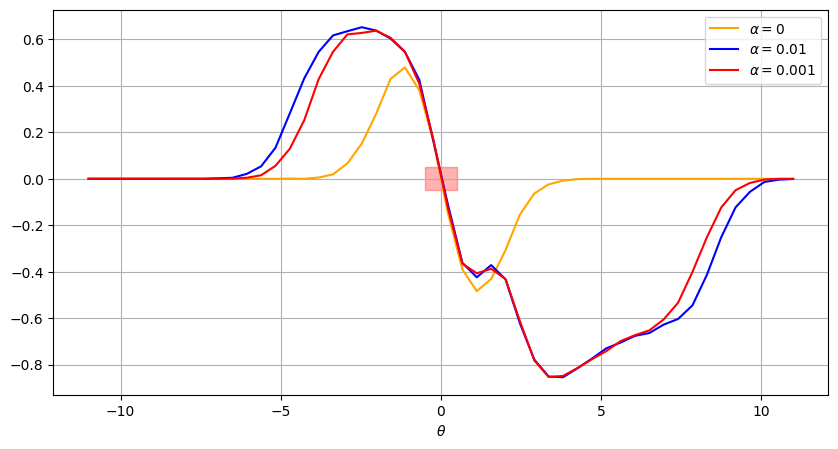

In [6]:
plt.figure(figsize=(10, 5))

plt.plot(theta_values, np.mean(all_grad_0,0), color='orange', label="$\\alpha=0$")
plt.plot(theta_values, np.mean(all_grad_01,0), color='blue', label="$\\alpha=0.01$")
plt.plot(theta_values, np.mean(all_grad_001,0), color='red', label="$\\alpha=0.001$")

plt.fill_betweenx([-0.05, 0.05], c.lower_target, -c.lower_target, color='red', alpha=0.3)
plt.legend()
plt.grid(True)
plt.xlabel("$\\theta$")
plt.show()

Above, we plot the gradient of our GRPO algorithm:
$$
\frac{1}{G}\sum_{g=1}^G \nabla_\theta\left(\frac{\pi_{\theta}(o_g)}{\pi_{\text{old}}(o_g)} A(o_g) \right) = \frac{1}{G}\sum_{g=1}^G (o_g-\theta) \frac{r_i - \textbf{mean}(r_1,\dots, r_G)}{\textbf{std}(r_1,\dots, r_G)}
$$

We see that the gradient points towards the target $\theta^*=0$.

Below, we integrate the gradient to see the optimization landscape of GRPO that we call the virtual global reward. This is the function optimized by GRPO.

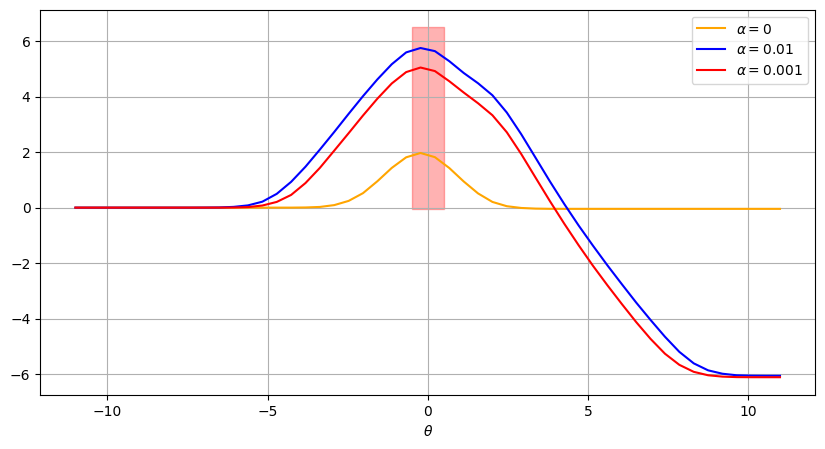

In [7]:
plt.figure(figsize=(10, 5))

plt.plot(theta_values, np.cumsum(np.mean(all_grad_0,0)), color='orange', label="$\\alpha=0$")
plt.plot(theta_values, np.cumsum(np.mean(all_grad_01,0)), color='blue', label="$\\alpha=0.01$")
plt.plot(theta_values, np.cumsum(np.mean(all_grad_001,0)), color='red', label="$\\alpha=0.001$")

plt.fill_betweenx([-0.05, 6.5], c.lower_target, -c.lower_target, color='red', alpha=0.3)
plt.legend()
plt.grid(True)
plt.xlabel("$\\theta$")
plt.show()

In [ ]:
n_samples = 10
theta_values = np.linspace(-11, 11, 50)
n_simu = 1000
alpha_values = np.linspace(0,0.001,10)

all_grad = np.zeros((len(alpha_values), len(theta_values)))
all_reward = np.zeros((len(alpha_values), len(theta_values)))
for (a,alpha) in enumerate(alpha_values):
    g.alpha=alpha
    all_reward[a,:] = np.asarray([g.reward(x) for x in theta_values])
    for (b,theta) in enumerate(theta_values):
        g.theta_0 = theta
        grad_values = []
        for i in range(n_simu):
            x_samples = g.sample_batch(n_samples)
            grad_values.append(g.empirical_grad(x_samples))
        all_grad[a,b] = np.mean(np.asarray(grad_values))

In [ ]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

theta_mesh, alpha_mesh = np.meshgrid(theta_values, alpha_values)

ax.plot_surface(theta_mesh,alpha_mesh, np.cumsum(all_grad,1), cmap='viridis')
ax.set_xlabel('$\\theta$')
ax.set_ylabel('$\\alpha$')
plt.title('Global Virtual Reward')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.contourf(theta_values, alpha_values, np.cumsum(all_grad,1), cmap='viridis')
plt.colorbar()
plt.xlabel("$\\theta$")
plt.ylabel("$\\alpha$")
plt.title("Contour plot of the global virtual reward")
plt.vlines(x=0, ymin=0, ymax=0.001, colors='red', ls=':', lw=2, label='target')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.contourf(theta_values, alpha_values, all_grad, cmap='viridis')
plt.colorbar()
plt.xlabel("$\\theta$")
plt.ylabel("$\\alpha$")
plt.title("Contour plot of the gradient for GRPO")
plt.vlines(x=0, ymin=0, ymax=0.001, colors='red', ls=':', lw=2, label='target')
plt.legend()
plt.show()

Even a very small modification of the reward (see below) has a very large impact on the GRPO algorithm. As soon as $\alpha>0$, the performances increase a lot with a gradient towards the target

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(theta_mesh,alpha_mesh, all_reward, cmap='viridis')
ax.set_xlabel('$\\theta$')
ax.set_ylabel('$\\alpha$')
plt.title('Reward function')
plt.show()

Now, we fix $\alpha=0.001$ and we consider 3 different reward functions corresponding to a target $t=0$: $r_\delta(\theta) = (1-\alpha)\mathbf{1}(\theta\in [-\eta,\eta])+\alpha \exp(-(\theta-\delta)^2/2$ for $\delta=2, 3$ and $4$.

In [ ]:
n_samples = 10
theta_values = np.linspace(-11, 11, 50)
n_simu = 1000

g.alpha=0.001
g.delta=2
all_grad_2 = np.zeros((n_simu, len(theta_values)))
for i in range(n_simu):
    grad_values = []
    for theta in theta_values:
        g.theta_0 = theta
        grad_values.append(g.group_grad(n_samples))
    all_grad_2[i,:] = np.asarray(grad_values)

g.delta=3
all_grad_3 = np.zeros((n_simu, len(theta_values)))
for i in range(n_simu):
    grad_values = []
    for theta in theta_values:
        g.theta_0 = theta
        grad_values.append(g.group_grad(n_samples))
    all_grad_3[i,:] = np.asarray(grad_values)

g.delta= 4    
all_grad_4 = np.zeros((n_simu, len(theta_values)))
for i in range(n_simu):
    grad_values = []
    for theta in theta_values:
        g.theta_0 = theta
        grad_values.append(g.group_grad(n_samples))
    all_grad_4[i,:] = np.asarray(grad_values)

In [ ]:
plt.figure(figsize=(10, 5))

plt.plot(theta_values, np.mean(all_grad_2,0), color='orange', label="$\\delta=2$")
plt.plot(theta_values, np.mean(all_grad_3,0), color='blue', label="$\\delta=3$")
plt.plot(theta_values, np.mean(all_grad_4,0), color='red', label="$\\delta=4$")

plt.fill_betweenx([-0.05, 0.05], c.lower_target, -c.lower_target, color='red', alpha=0.3)
plt.legend()
plt.grid(True)
plt.xlabel("$\\theta$")

plt.show()

Above, we see that when $\delta$ is too large, the gradient does not necessarily points toward the target but can get trapped at $\delta$.

Below, we integrate the gradient to see the optimization landscape of GRPO that we call the virtual global reward. This is the function optimized by GRPO.

In [ ]:
plt.figure(figsize=(10, 5))

plt.plot(theta_values, np.cumsum(np.mean(all_grad_2,0)), color='orange')
plt.plot(theta_values, np.cumsum(np.mean(all_grad_3,0)), color='blue')
plt.plot(theta_values, np.cumsum(np.mean(all_grad_4,0)), color='red')

plt.fill_betweenx([-0.05, 8.05], c.lower_target, -c.lower_target, color='red', alpha=0.3)

plt.grid(True)
plt.show()

In [ ]:
n_samples = 10
theta_values = np.linspace(-11, 11, 50)
n_simu = 1000
delta_values = np.linspace(0,7,10)
c = Config()
g = Gauss_GRPO(c)
g.alpha = 0.001

all_grad = np.zeros((len(delta_values), len(theta_values)))
all_reward = np.zeros((len(delta_values), len(theta_values)))
for (a,delta) in enumerate(delta_values):
    g.delta=delta
    all_reward[a,:] = np.asarray([g.reward(x) for x in theta_values])
    for (b,theta) in enumerate(theta_values):
        g.theta_0 = theta
        grad_values = []
        for i in range(n_simu):
            x_samples = g.sample_batch(n_samples)
            grad_values.append(g.empirical_grad(x_samples))
        all_grad[a,b] = np.mean(np.asarray(grad_values))

In [ ]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

theta_mesh, delta_mesh = np.meshgrid(theta_values, delta_values)

ax.plot_surface(theta_mesh,delta_mesh, np.cumsum(all_grad,1), cmap='viridis')
ax.set_xlabel('$\\theta$')
ax.set_ylabel('$\\delta$')
plt.title('Global Virtual Reward')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.contourf(theta_values, delta_values, np.cumsum(all_grad,1), cmap='viridis')
plt.colorbar()
plt.vlines(x=0, ymin=0, ymax=7, colors='red', ls=':', lw=2, label='target')
plt.xlabel("$\\theta$")
plt.ylabel("$\\delta$")
plt.title("Contour Plot of the global virtual reward")
plt.show()

We see that the global virtual reward is not aligned with the target for large values of $\delta$.

In [ ]:
plt.figure(figsize=(10, 6))
plt.contourf(theta_values, delta_values, all_grad, cmap='viridis')
plt.colorbar()
plt.xlabel("$\\theta$")
plt.ylabel("$\\delta$")
plt.title("Contour plot of the gradient for GRPO")
plt.vlines(x=0, ymin=0, ymax=7, colors='red', ls=':', lw=2, label='target')
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')



ax.plot_surface(theta_mesh,delta_mesh, all_reward, cmap='viridis')
ax.set_xlabel("$\\theta$")
ax.set_ylabel("$\\delta$")
plt.title('Reward')
plt.show()